In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# random seed for reproducibility
seed = 123456789
np.random.seed(seed)

raw_data = pd.read_csv("International students Time management data.csv")

#Question 6: You often feel that your life is aimless, with no definite purpose
target_column = '8'
raw_data = raw_data[raw_data[target_column] != 'Neither']
raw_data = raw_data[raw_data[target_column].notna()]
raw_data[target_column] = raw_data[target_column].replace('Strong Agree', 'Agree')
raw_data[target_column] = raw_data[target_column].replace('Strong Disagree', 'Disagree')

In [90]:
impute_and_one_hot = Pipeline([
    ('impute', SimpleImputer(strategy= 'most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

answers = ['Strong Disagree', 'Disagree', 'Neither', 'Agree', 'Strong Agree']
percentages = ['<40%', '40%~49%', '50%~59%', '60%~70%','>70%']

impute_and_ordinal = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[percentages,
                                           ['S4', 'S3', 'S2', 'S1', 'S0'], 
                                           percentages,
                                           ['<18', '18-20', '21-25', '26-30', '31-35', '>36'],
                                           answers, answers, answers, answers])),
    ('scaler', StandardScaler())
])

feature_encoding = ColumnTransformer([
    ("impute_and_one_hot", impute_and_one_hot, ['Course']),
    ("impute_and_ordinal", impute_and_ordinal,['Academic', 'Attendance', 'English', 'Age',  
                                                '6', '12', '14', '15'])
])

pipeline = Pipeline([
    ('features', feature_encoding),
    ('tree', DecisionTreeClassifier(random_state = 1))
])

In [91]:
hyperparam_grid = {
    "tree__splitter":["best","random"],
    "tree__max_depth" :[1, 2, 3, 4, 5],
    "tree__min_samples_leaf":[6, 8, 10],
    "tree__max_features":["auto","log2","sqrt", None],
    "tree__max_leaf_nodes":[2, 4, 6, 8, 10],
#    "tree__criterion": ["gini", "entropy"]
}

grid_search = GridSearchCV(pipeline, param_grid=hyperparam_grid, cv=3, n_jobs = -1, verbose = 1, return_train_score=True )

In [92]:
X_train, X_test, y_train_raw, y_test_raw = \
  train_test_split(raw_data, raw_data[target_column], test_size=.3, random_state=seed)

y_train = np.squeeze(label_binarize(y_train_raw, classes=['Agree', 'Disagree']))
y_test = np.squeeze(label_binarize(y_test_raw, classes=['Agree', 'Disagree']))

model = grid_search.fit(X_train, y_train)

print(model.best_params_)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   13.8s


{'tree__max_depth': 1, 'tree__max_features': 'auto', 'tree__max_leaf_nodes': 2, 'tree__min_samples_leaf': 6, 'tree__splitter': 'best'}


[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   14.8s finished


In [112]:
X_train.shape

(60, 21)

In [93]:
model.score(X_train, y_train)

0.8333333333333334

In [94]:
model.score(X_test, y_test)

0.7692307692307693

In [80]:
confusion_matrix(y_test, model.predict(X_test))

array([[20,  0],
       [ 6,  0]], dtype=int64)

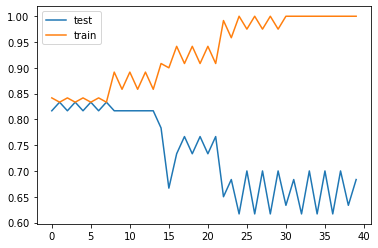

In [56]:
import matplotlib.pyplot as plt

test_scores = model.cv_results_['mean_test_score']
train_scores = model.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [102]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

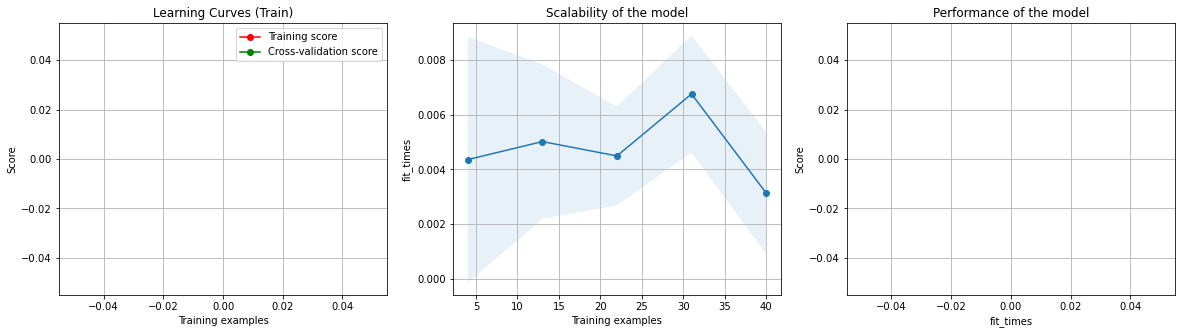

In [109]:
X, y = X_train, y_train
title = "Learning Curves (Train)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = DecisionTreeClassifier()
# plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01),
#                     cv=3, n_jobs= -1)

plot_learning_curve(estimator, title, X, y,
                    cv=3, n_jobs= -1)


plt.show()

In [110]:
learning_curve(DecisionTreeClassifier(), X_train, y_train, cv = 3, scoring = 'accuracy', n_jobs = -1, train_sizes = np.linspace(0.01, 1, 50), verbose = 1)

c:\users\nchau\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:1323: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes' 40 instead of 50).
  warnings.warn("Removed duplicate entries from 'train_sizes'. Number "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40]),
 array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, 

In [117]:
train_sizes = [1, 5, 10, 15, 20, 25, 30, 35]

train_sizes, train_scores, validation_scores = learning_curve(
estimator = DecisionTreeClassifier(),
X = X_train,
y = y_train, train_sizes = train_sizes, cv = 3,
scoring = 'neg_mean_squared_error')

print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]

 ----------------------------------------------------------------------

Validation scores:

 [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]


c:\users\nchau\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '21-25'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\nchau\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '21-25'

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\users\nchau\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Val